In [9]:
import sys
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import pandas as pd
import seaborn as sns

sys.path.append('../')
from model.cnf import AugmentedCNF
from model.flow_matching import FlowMatching
from model.utils import BoundingBox

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model

In [15]:
# CNF-trained model
# Verlet CNF
wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_weird_gaussian_test/epoch=17-val_loss=5.63.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_funnel_test/epoch=119-val_loss=5.78.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_bimodal_test/epoch=65-val_loss=4.82.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_trimodal_test/epoch=89-val_loss=5.71.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_pentamodal_test/epoch=59-val_loss=6.42.ckpt').export_to_wrapper()
# Taylor-Verlet CNF
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/taylor_verlet_test0/epoch=20-val_loss=5.74.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/taylor_verlet_test3/epoch=26-val_loss=5.71.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/ord2_verlet_weird_gaussian_cnf4/epoch=23-val_loss=5.79.ckpt').export_to_wrapper()
# Non-Verlet CNF
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/nonverlet_cnf_pentamodal_test/epoch=41-val_loss=5.80.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_trimodal_test/epoch=89-val_loss=5.71.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/grad_nonverlet_cnf_trimodal0/epoch=05-val_loss=6.14.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_trimodal1/epoch=53-val_loss=6.08.ckpt').export_to_wrapper()
# wrapper = AugmentedCNF.load_from_checkpoint('../workdir/verlet_cnf_weird_gaussian1/epoch=50-val_loss=5.70.ckpt').export_to_wrapper()
# Flow-matching-trained model
# wrapper = FlowMatching.load_from_checkpoint('../workdir/grad_nonverlet_flowmatching_trimodal0/epoch=23-val_loss=0.41.ckpt').export_to_wrapper()

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


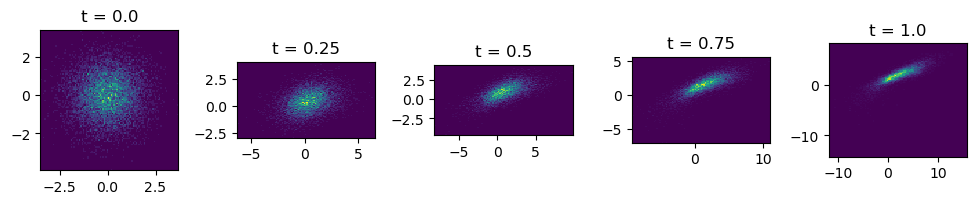

In [32]:
wrapper.graph_forward_marginals(n_samples=10000, n_marginals=5, n_integrator_steps=60, integrator='verlet')

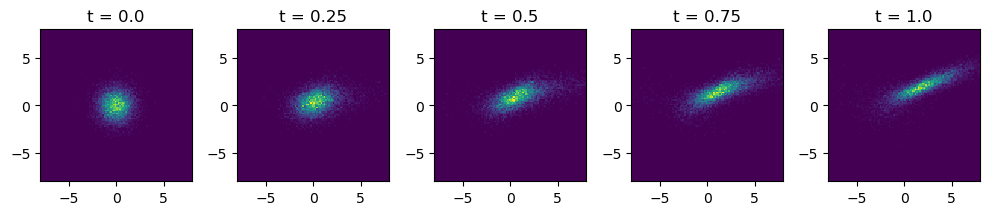

In [30]:
wrapper.graph_forward_marginals(n_samples=10000, n_marginals=5, n_integrator_steps=60, integrator='taylor_verlet', xlim=8, ylim=8)

Using Autograd Trace
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Numerically integrating with 60 steps


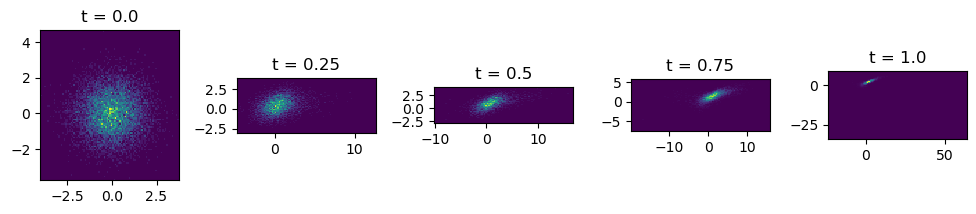

In [41]:
wrapper.graph_forward_marginals(n_samples=10000, n_marginals=5, n_integrator_steps=60, integrator='numeric')

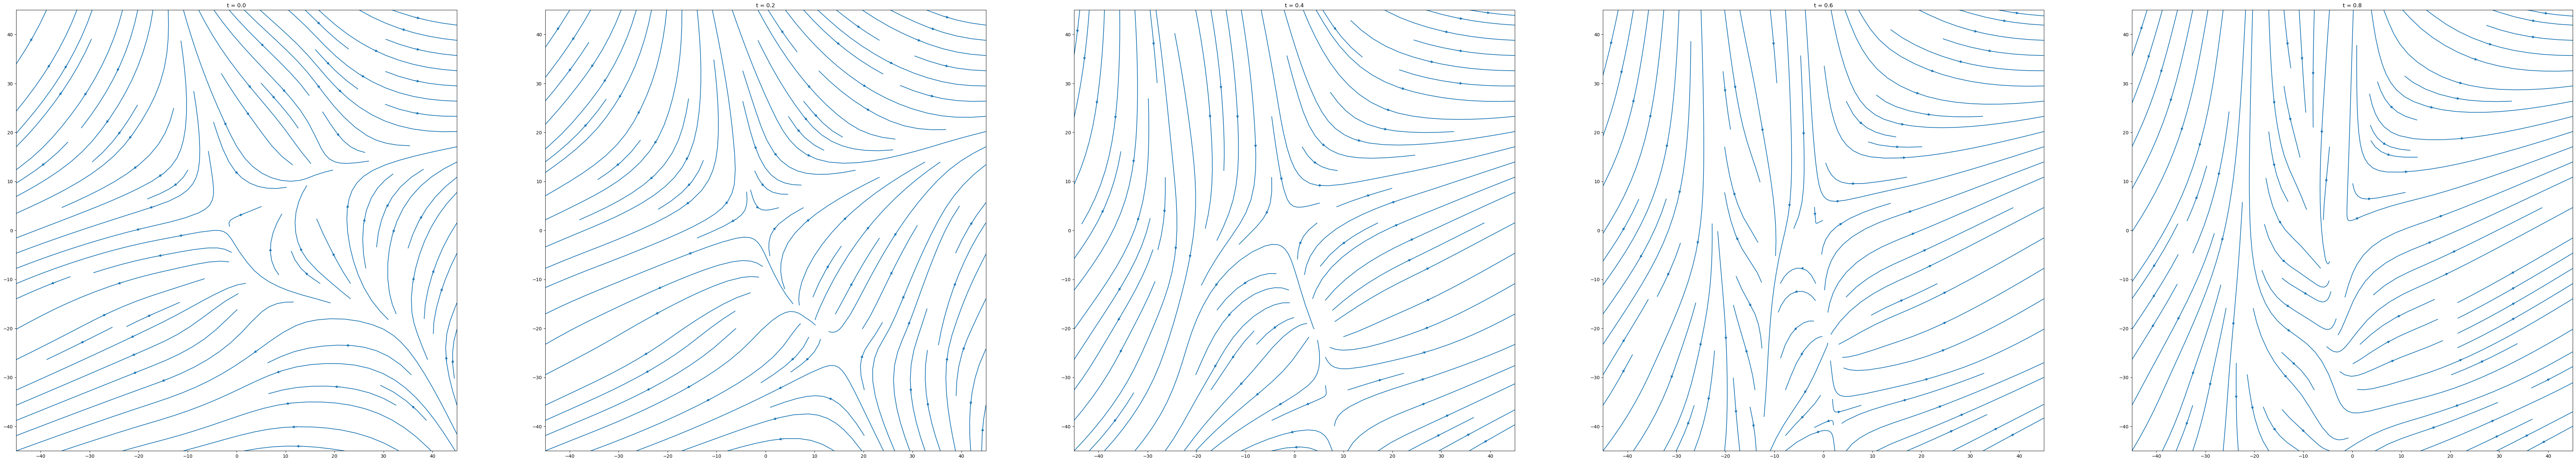

In [40]:
wrapper.graph_flow_marginals(bins=40, xlim=45, ylim=45)

In [16]:
wrapper.reverse_kl(integrator='verlet')

tensor(0.0196, device='cuda:0', grad_fn=<MeanBackward0>)

In [14]:
wrapper.reverse_kl(integrator='taylor_verlet', filter=True, filter_bounds = BoundingBox(0,0,8.0,5.0))

tensor(0.1425, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
wrapper.graph_flow_marginals(mode='quiver')

# Graphing Importance Weights Using Hutchinson Trace Estimator

In [ ]:
estimates,log_importance_weights = wrapper.estimate_z(n_sample=100000, n_steps=100, integrator='numeric', trace_estimator='hutch_trace', n_trial=1)

In [ ]:
# Compute importance_weights
weights_df = pd.DataFrame({
    'Log Importance Weights': log_importance_weights.detach().cpu().numpy(),  # Convert the tensor to a numpy array
})

In [ ]:
g = sns.histplot(weights_df, x='Log Importance Weights')
g.set(title='Histogram of Log Importance Weights for Trimodal GMM\n Using Hutchinson Trace Estimator')
fig = g.get_figure()
fig.savefig('weights_hist.png')

# logZ Estimation

In [ ]:
@torch.no_grad()
def get_estimates(wrapper, n_samples: list[int], n_steps: int, n_trials: int, integrator: str) -> pd.DataFrame:
    # Initialize an empty list to hold the dataframes to concatenate
    list_of_dataframes = []
    # Initialize method
    if integrator == 'verlet':
        method = 'Verlet'
    elif integrator == 'numeric':
        method = 'Adjoint w/ autograd trace'
    
    for n_sample in tqdm.tqdm(n_samples):
        start = time.time()
        z_estimates = wrapper.estimate_z_wrapper(n_sample, n_steps, integrator, trace_estimator='autograd_trace', n_trial=n_trials)
        end = time.time()
        # Create a DataFrame from the current batch of estimates and add it to the list
        current_df = pd.DataFrame({
            'log Z Estimate': z_estimates.detach().cpu().numpy(),  # Convert the tensor to a numpy array
            'Samples': n_sample,
            'Method': method,
            'Time (s)': end - start
        })
        list_of_dataframes.append(current_df)
    
    # Concatenate all the dataframes in the list into one dataframe
    estimates = pd.concat(list_of_dataframes, ignore_index=True)
    
    return estimates

In [ ]:
# load up estimates.csv
estimates = pd.read_csv('estimates.csv')

In [ ]:
# Setup
n_samples_list = np.rint(np.power(5.0, np.linspace(4.0, 5.5, 20))).astype(int).tolist()
n_steps = 100
n_trials = 150

# Compute
numeric_estimates = get_estimates(wrapper, n_samples_list, n_steps, n_trials=n_trials, integrator='numeric')
verlet_estimates = get_estimates(wrapper, n_samples_list, n_steps, n_trials=n_trials, integrator='verlet')
estimates = pd.concat([verlet_estimates, numeric_estimates], ignore_index=True)

# Save estimates
estimates.to_csv('estimates.csv', index=False)

## Graphing Results

In [ ]:
# Graph log Z 
g = sns.lineplot(data=estimates, x="Samples", y="log Z Estimate", hue="Method", errorbar=("sd",1))
g.set(xscale='log')
g.set(xticks=n_samples_list[::3])
g.set(xticklabels=n_samples_list[::3])
g.set(title='Comparison of log Z Estimates for Trimodal GMM')
fig = g.get_figure()
fig.savefig('test_compare.png')

In [ ]:
# Graph time
g = sns.lineplot(data=estimates, x="Samples", y="Time (s)", hue="Method")
g.set(xscale='log')
g.set(xticks=n_samples_list[::3])
g.set(xticklabels=n_samples_list[::3])
g.set(title='Comparison of log Z Estimation Times for Trimodal GMM')
fig = g.get_figure()
fig.savefig('test_time.png')